In [4]:
from sklearn.datasets import load_files       
from keras.utils import to_categorical
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

#load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [5]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


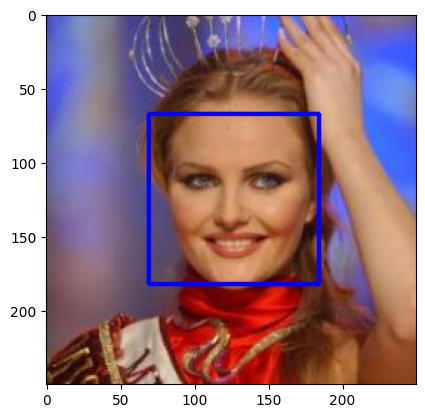

In [6]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[2])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [7]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.


In [8]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_file_cnt = 0
for file in human_files_short:
    if face_detector(file) == True:
        human_file_cnt += 1
print("% detected human face in human_files :",human_file_cnt,"%")

dog_file_cnt = 0
for file in dog_files_short:
    if face_detector(file) == True:
        dog_file_cnt += 1
print("% detected human face in dog_files :",dog_file_cnt,"%")

% detected human face in human_files : 99 %
% detected human face in dog_files : 12 %


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [60]:
from keras.applications.resnet50 import ResNet50
from PIL import Image


# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [10]:
from PIL import Image
from tensorflow.keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [11]:
from keras.applications.resnet50 import preprocess_input, decode_predictions
from PIL import Image


def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector


In [13]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
from PIL import Image


human_file_cnt = 0
for file in human_files_short:
    if dog_detector(file) == True:
        human_file_cnt += 1
print("% detected dog face in human_files :",human_file_cnt,"%")

dog_file_cnt = 0
for file in dog_files_short:
    if dog_detector(file) == True:
        dog_file_cnt += 1
print("% detected dog face in dog_files :",dog_file_cnt,"%")

1/1 [==============================] - 0s 81ms/step
% detected dog face in human_files : 0 %
1/1 [==============================] - 0s 76ms/step
% detected dog face in dog_files : 100 %


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [14]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:02<00:00, 299.44it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

i chose the hinted architecture, because I think three convolutional layer with three pooling layer is a pretty reasonable starting point, and filter number gets bigger and bigger which will extract more features. and use pooling layer to maitain a relatively small parameter level. the activation fuction using 'relu' is better than the sigmoid, because it can avoid the gradient vanishing problem. Since we want to categorize 133 dog breed, at the end, adding a dense layer of 133, with a softmax

In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
#conlolution layer
model.add(Conv2D(filters=16, kernel_size=2,padding='same',activation='relu',
                       input_shape=(224,224,3)))
#maxpooling layer
model.add(MaxPooling2D(pool_size=2))
#convolution layer
model.add(Conv2D(filters=32, kernel_size=2,padding='same',activation='relu'))
#maxpooling layer
model.add(MaxPooling2D(pool_size=2))
#convolution layer
model.add(Conv2D(filters=64, kernel_size=2,padding='same',activation='relu'))
#maxpooling layer
model.add(MaxPooling2D(pool_size=2)) 

#global avg pooling layer
model.add(GlobalAveragePooling2D())
#output layer
model.add(Dense(133,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

### Compile the Model

In [16]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [17]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 2

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/2
334/334 [==============================] - ETA: 0s - loss: 4.8844 - accuracy: 0.0088
Epoch 1: val_loss improved from inf to 4.87172, saving model to saved_models\weights.best.from_scratch.hdf5
334/334 [==============================] - 82s 245ms/step - loss: 4.8844 - accuracy: 0.0088 - val_loss: 4.8717 - val_accuracy: 0.0132


C:\Users\idris\anaconda3\envs\tensorflow\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/2
334/334 [==============================] - ETA: 0s - loss: 4.8665 - accuracy: 0.0121
Epoch 2: val_loss improved from 4.87172 to 4.85595, saving model to saved_models\weights.best.from_scratch.hdf5
334/334 [==============================] - 73s 218ms/step - loss: 4.8665 - accuracy: 0.0121 - val_loss: 4.8560 - val_accuracy: 0.0168


### Load the Model with the Best Validation Loss

In [18]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [19]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 20ms/step
Test accuracy: 1.9139%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [20]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [21]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 133)               68229     
                                                                 
Total params: 68229 (266.52 KB)
Trainable params: 68229 (266.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compile the Model

In [22]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [23]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
324/334 [============================>.] - ETA: 0s - loss: 7.7678 - accuracy: 0.2302
Epoch 1: val_loss improved from inf to 3.75132, saving model to saved_models\weights.best.VGG16.hdf5
334/334 [==============================] - 1s 3ms/step - loss: 7.6525 - accuracy: 0.2370 - val_loss: 3.7513 - val_accuracy: 0.4216
Epoch 2/20
333/334 [============================>.] - ETA: 0s - loss: 2.1692 - accuracy: 0.5989
Epoch 2: val_loss improved from 3.75132 to 2.47467, saving model to saved_models\weights.best.VGG16.hdf5
334/334 [==============================] - 1s 2ms/step - loss: 2.1702 - accuracy: 0.5991 - val_loss: 2.4747 - val_accuracy: 0.5964
Epoch 3/20
314/334 [===========================>..] - ETA: 0s - loss: 1.2260 - accuracy: 0.7449
Epoch 3: val_loss improved from 2.47467 to 2.18545, saving model to saved_models\weights.best.VGG16.hdf5
334/334 [==============================] - 1s 2ms/step - loss: 1.2434 - accuracy: 0.7449 - val_loss: 2.1855 - val_accuracy: 0.6335
Epoch 4/

### Load the Model with the Best Validation Loss

In [24]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [25]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 16ms/step
Test accuracy: 73.5646%


### Predict Dog Breed with the Model

In [26]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return predicted_vector.shape,np.argmax(predicted_vector), dog_names[np.argmax(predicted_vector)]

In [27]:
dog_names[94]

'Kuvasz'

In [28]:
for file in dog_files_short[:1]:
    print(VGG16_predict_breed(file))

1/1 [==============================] - 0s 15ms/step
((1, 133), 94, 'Kuvasz')


---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [29]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')

train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
the architecture is freeze all the layers in Resnet50 before the last layer and add a global average pooling, and end up with a dense layer with softmax activation function. since we want to use the pre-trained model Resnet50, so we take the freezing part as input and use global average pooling to downsize the sample and reducing the dimensionality. the last dense layer keep unchanged since the we want a 133 category identification output.

In [31]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential


### TODO: Define your architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 133)               272517    
                                                                 
Total params: 272517 (1.04 MB)
Trainable params: 272517 (1.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [32]:
### TODO: Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [34]:
from keras.callbacks import ModelCheckpoint  
### TODO: Train the model.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50_model.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=5, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/5
323/334 [============================>.] - ETA: 0s - loss: 0.0820 - accuracy: 0.9779
Epoch 1: val_loss improved from inf to 0.64763, saving model to saved_models\weights.best.Resnet50_model.hdf5
334/334 [==============================] - 1s 3ms/step - loss: 0.0816 - accuracy: 0.9781 - val_loss: 0.6476 - val_accuracy: 0.8120
Epoch 2/5
328/334 [============================>.] - ETA: 0s - loss: 0.0562 - accuracy: 0.9851
Epoch 2: val_loss did not improve from 0.64763
334/334 [==============================] - 1s 3ms/step - loss: 0.0577 - accuracy: 0.9846 - val_loss: 0.6544 - val_accuracy: 0.8228
Epoch 3/5
320/334 [===========================>..] - ETA: 0s - loss: 0.0397 - accuracy: 0.9909
Epoch 3: val_loss improved from 0.64763 to 0.63099, saving model to saved_models\weights.best.Resnet50_model.hdf5
334/334 [==============================] - 1s 3ms/step - loss: 0.0404 - accuracy: 0.9907 - val_loss: 0.6310 - val_accuracy: 0.8240
Epoch 4/5
323/334 [============================>.] 

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [35]:
### TODO: Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50_model.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [36]:
### TODO: Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 17ms/step
Test accuracy: 82.5359%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [37]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [38]:
for file in dog_files_short[:2]:
    print(Resnet50_predict_breed(file))

1/1 [==============================] - 0s 34ms/step
Kuvasz
1/1 [==============================] - 0s 17ms/step
Dalmatian


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!


### (IMPLEMENTATION) Write your Algorithm

In [39]:
def print_img(file):
        img = cv2.imread(file)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()

In [54]:
def dog_breed_detection(file):
    if dog_detector(file) == True:
        print('Hello Dog!')
        print_img(file)
        print('You look like a ...',  Resnet50_predict_breed(file))
        print("###################################################")
    if face_detector(file) == True:
        print('Hello Human!')
        print_img(file)
        print('You look like a ...',  Resnet50_predict_breed(file))
        print("###################################################")
    else:
        print_img(file)
        print ("Error:neither dog or human")
        print("###################################################")


1/1 [==============================] - 0s 110ms/step
Hello Human!


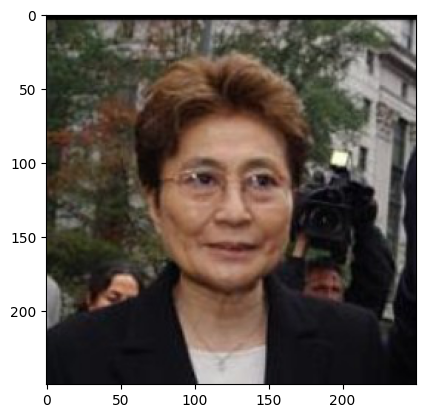

1/1 [==============================] - 0s 17ms/step
You look like a ... Black_russian_terrier
###################################################


In [66]:
for file in human_files_short[1:2]:
    dog_breed_detection(file)

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  


In [61]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

import os
import glob

def load_my_dataset(path):
    my_files = np.array(glob.glob(os.path.join(path, '*.jpg')))
    return my_files


In [62]:
my_photo =load_my_dataset('dogImages/Me')

In [63]:
my_photo

array(['dogImages/Me\\cat_1.jpg', 'dogImages/Me\\golden.jpg',
       'dogImages/Me\\hushky.jpg', 'dogImages/Me\\idris.jpg',
       'dogImages/Me\\kanan.jpg'], dtype='<U23')

1/1 [==============================] - 1s 1s/step


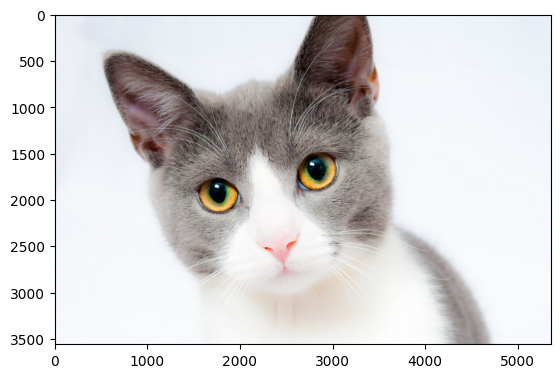

Error:neither dog or human
###################################################
1/1 [==============================] - 0s 143ms/step
Hello Dog!


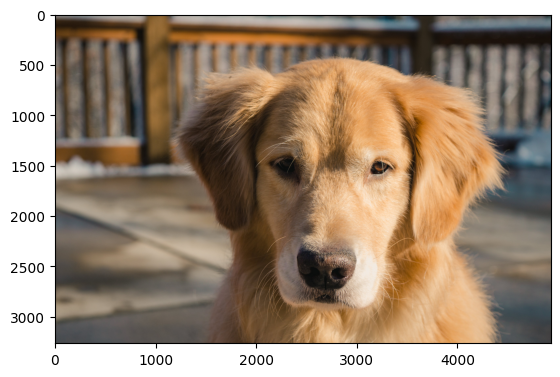

1/1 [==============================] - 0s 17ms/step
You look like a ... Golden_retriever
###################################################


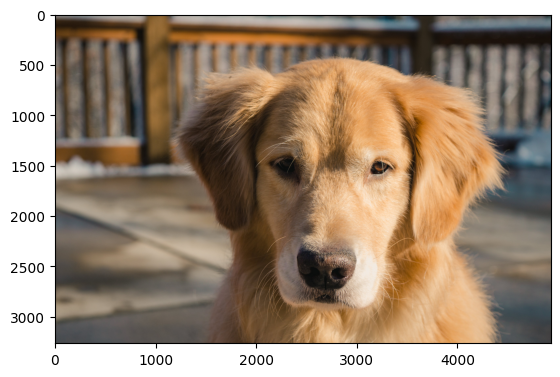

Error:neither dog or human
###################################################
1/1 [==============================] - 0s 109ms/step
Hello Dog!


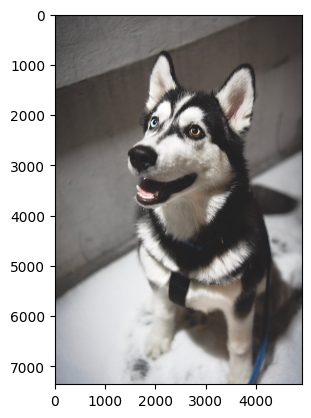

1/1 [==============================] - 0s 17ms/step
You look like a ... Alaskan_malamute
###################################################
Hello Human!


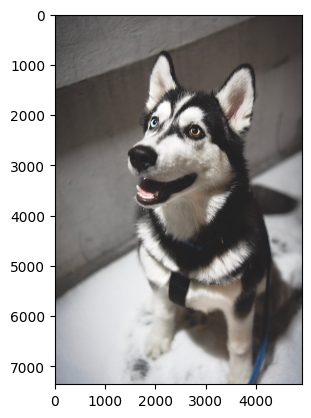

1/1 [==============================] - 0s 17ms/step
You look like a ... Alaskan_malamute
###################################################
1/1 [==============================] - 0s 105ms/step
Hello Human!


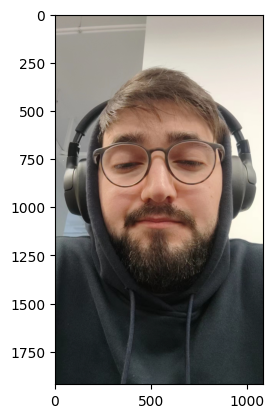

1/1 [==============================] - 0s 17ms/step
You look like a ... Xoloitzcuintli
###################################################
1/1 [==============================] - 0s 104ms/step
Hello Human!


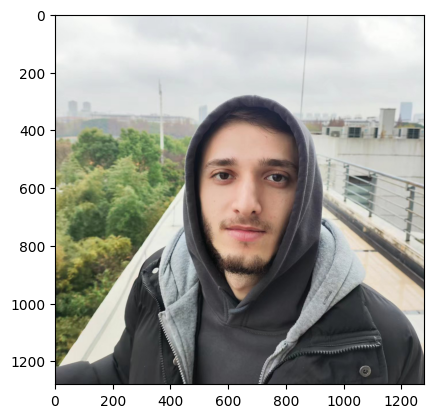

1/1 [==============================] - 0s 17ms/step
You look like a ... Xoloitzcuintli
###################################################


In [64]:
for file in my_photo:
    dog_breed_detection(file)